⚠️ File not found locally, please upload city_day_cleaned.csv


Saving city_day_cleaned.csv to city_day_cleaned.csv
Train size: (1607, 2) Test size: (402, 2)

Training ARIMA...

Training Prophet...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwdm7fna/lop5ds6z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwdm7fna/bzlhtqqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78743', 'data', 'file=/tmp/tmpdwdm7fna/lop5ds6z.json', 'init=/tmp/tmpdwdm7fna/bzlhtqqr.json', 'output', 'file=/tmp/tmpdwdm7fna/prophet_model0ejypzs2/prophet_model-20250917135312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:53:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:53:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Training LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0821
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Model Comparison:
      Model        RMSE        MAE
0    ARIMA  122.318929  88.112164
1  Prophet   79.001532  61.574428
2     LSTM   48.099914  37.149059


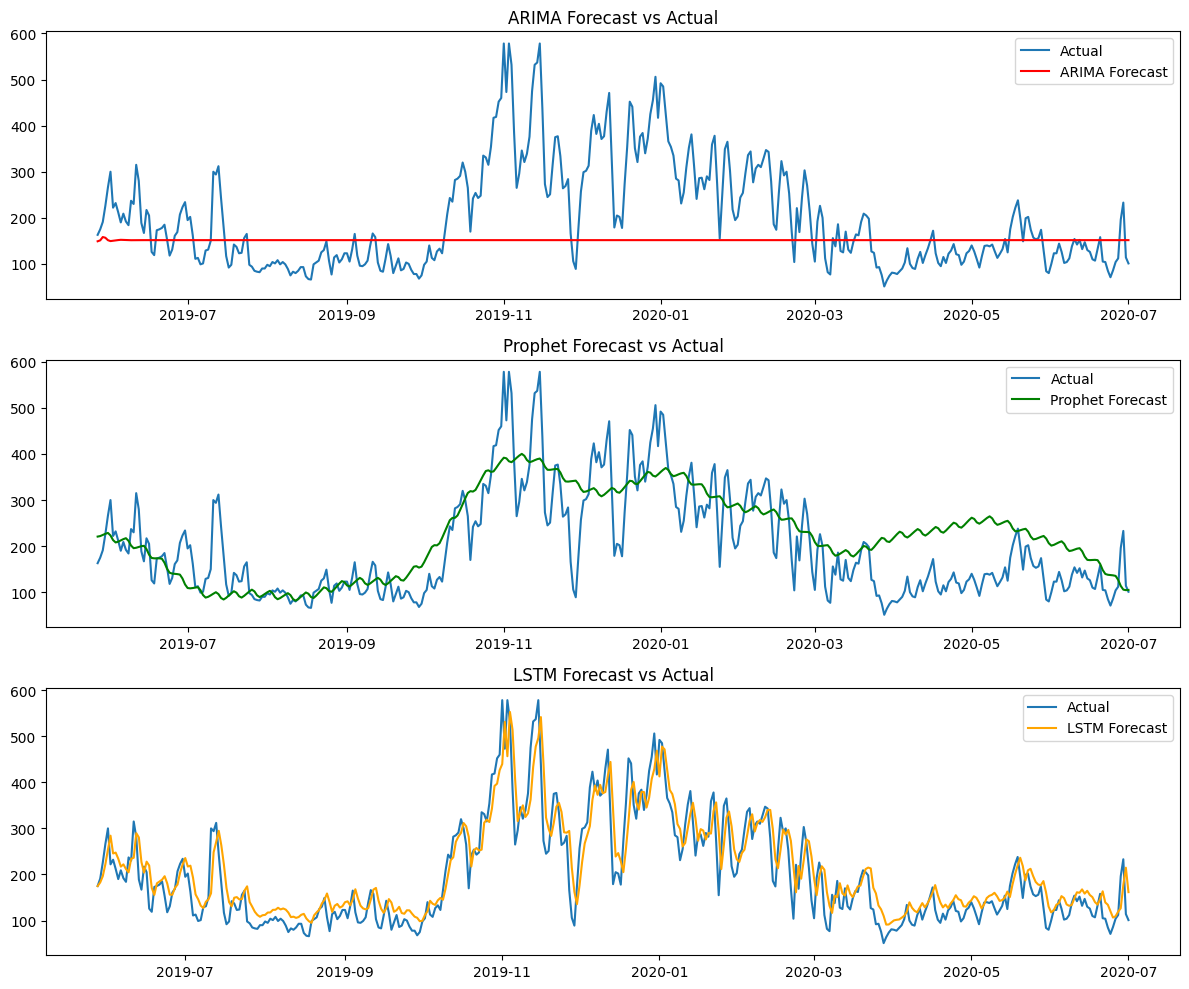


✅ Best model is: LSTM
LSTM model saved as best_model_lstm.h5


In [3]:
# ===========================================
# Milestone 2: Model Training, Evaluation & Visualization
# AirAware - Smart AQI Prediction System
# ===========================================

# Step 1: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

# Time-series models
import statsmodels.api as sm
from prophet import Prophet

# Deep Learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 2: Load Preprocessed Data (from Milestone 1)
csv_path = "../Milestone1/city_day_cleaned.csv"

if os.path.exists(csv_path):
    print("✅ Found dataset in Milestone1 folder")
    df = pd.read_csv(csv_path)
else:
    print("⚠️ File not found locally, please upload city_day_cleaned.csv")
    from google.colab import files
    uploaded = files.upload()   # upload city_day_cleaned.csv manually in Colab
    df = pd.read_csv("city_day_cleaned.csv")

df["Date"] = pd.to_datetime(df["Date"])

# Example: Focus on Delhi (you can change city name)
city = "Delhi"
df_city = df[df["City"] == city].sort_values("Date")

# Target = AQI
target = "AQI"
data = df_city[["Date", target]].dropna().reset_index(drop=True)

# Step 3: Train-Test Split
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
print("Train size:", train.shape, "Test size:", test.shape)

# ==============================
# Model 1: ARIMA
# ==============================
print("\nTraining ARIMA...")
arima_model = sm.tsa.ARIMA(train[target], order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test[target], arima_pred))
arima_mae = mean_absolute_error(test[target], arima_pred)

# ==============================
# Model 2: Prophet
# ==============================
print("\nTraining Prophet...")
prophet_df = train.rename(columns={"Date": "ds", target: "y"})
prophet = Prophet()
prophet.fit(prophet_df)

future = prophet.make_future_dataframe(periods=len(test))
forecast = prophet.predict(future)

prophet_pred = forecast.tail(len(test))["yhat"].values
prophet_rmse = np.sqrt(mean_squared_error(test[target], prophet_pred))
prophet_mae = mean_absolute_error(test[target], prophet_pred)

# ==============================
# Model 3: LSTM
# ==============================
print("\nTraining LSTM...")
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data[[target]])

# Sequence creation
def create_sequences(series, time_steps=5):
    X, y = [], []
    for i in range(len(series)-time_steps):
        X.append(series[i:i+time_steps])
        y.append(series[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 5
X, y = create_sequences(scaled, time_steps)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation="relu", input_shape=(time_steps,1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer="adam", loss="mse")

# Train
lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# Predict
lstm_pred = lstm_model.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled, lstm_pred_rescaled))
lstm_mae = mean_absolute_error(y_test_rescaled, lstm_pred_rescaled)

# ==============================
# Compare Results
# ==============================
results = pd.DataFrame({
    "Model": ["ARIMA","Prophet","LSTM"],
    "RMSE": [arima_rmse, prophet_rmse, lstm_rmse],
    "MAE": [arima_mae, prophet_mae, lstm_mae]
})
print("\nModel Comparison:\n", results)

# ==============================
# Visualization
# ==============================
plt.figure(figsize=(12,10))

# ARIMA
plt.subplot(3,1,1)
plt.plot(test["Date"], test[target], label="Actual")
plt.plot(test["Date"], arima_pred, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast vs Actual")
plt.legend()

# Prophet
plt.subplot(3,1,2)
plt.plot(test["Date"], test[target], label="Actual")
plt.plot(test["Date"], prophet_pred, label="Prophet Forecast", color="green")
plt.title("Prophet Forecast vs Actual")
plt.legend()

# LSTM
plt.subplot(3,1,3)
plt.plot(test["Date"][-len(y_test_rescaled):], y_test_rescaled, label="Actual")
plt.plot(test["Date"][-len(lstm_pred_rescaled):], lstm_pred_rescaled, label="LSTM Forecast", color="orange")
plt.title("LSTM Forecast vs Actual")
plt.legend()

plt.tight_layout()
plt.show()

# ==============================
# Save Best Model
# ==============================
best_model = results.sort_values("RMSE").iloc[0]["Model"]
print("\n✅ Best model is:", best_model)

if best_model == "ARIMA":
    joblib.dump(arima_fit, "best_model.pkl")
    print("ARIMA model saved as best_model.pkl")
elif best_model == "Prophet":
    joblib.dump(prophet, "best_model.pkl")
    print("Prophet model saved as best_model.pkl")
else:
    lstm_model.save("best_model_lstm.h5")
    print("LSTM model saved as best_model_lstm.h5")
